# Reproducing original demo
If we did this right, we should see similar output to the [original demo](https://zenodo.org/record/3866253#.Ydyk6GDMKUk) using spikes from a Brunel-Wang E-I network.

It should be slightly different since I noticed what seem to be errors in the original Python code:
1. The axonal propagation delay term `dist/va` yielded seconds, rather than milliseconds as it was supposed to. This seems to be the case in the `.hoc` code as well.
2. The `calc_LFP()` function used the inhibitory value `s_i` (that is, $2 \sigma^2$) for all cells rather than using the `s_e` for excitatory cells. This doesn't appear to be the case in the `.hoc` code.
3. The inhibitory and excitatory amplitudes were switched (e.g., `amp[:Ne] *= amp_i` instead of `amp_e`). This doesn't appear to be the case in the `.hoc` code.

We'll follow along with the original code and copy most of it.

## Read data in vectors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

N = 5000  # nb of cells to consider
Ne = 4000  # nb of excitatory cells
Ni = 1000  # nb of inhibitory cells

tmin = 9000  # min time (to skip)
tmax = 1000  # max time

# we read in the data the same as the original code
dtype = {"names": ["cellid", "time"], "formats": ["i4", "f8"]}
inh_cells = np.loadtxt("brunel_inh.txt", dtype=dtype)
exc_cells = np.loadtxt("brunel_exc.txt", dtype=dtype)

# adjust time and convert to ms
inh_cells["time"] = inh_cells["time"] * 1000 - tmin
exc_cells["time"] = exc_cells["time"] * 1000 - tmin
# for inhibitory cells, ids start from Ne
inh_cells["cellid"] += Ne

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Distribute cells in a 2D grid

In [2]:
xmax = 0.2  # size of the array (in mm)
ymax = 0.2

# make reproducible
np.random.seed(1830)

X, Y = np.random.rand(2, N) * np.array([[xmax, ymax]]).T
Z = np.zeros(N)  # record with all cells at soma layer

## Calculate LFP

In [3]:
from tklfp import TKLFP

# create a vector representing cell type
is_excitatory = np.arange(N) < Ne
tklfp = TKLFP(X, Y, Z, is_excitatory, elec_coords_mm=[[xmax / 2, ymax / 2, 0]])
i_spikes = np.concatenate((exc_cells['cellid'], inh_cells['cellid']))
t_spikes = np.concatenate((exc_cells['time'], inh_cells['time']))

dt = 0.1  # time resolution
npts = int(tmax / dt)
t_eval_ms = np.arange(npts) * dt

lfp = tklfp.compute(i_spikes, t_spikes, t_eval_ms)

<class 'scipy.interpolate._interpolate.interp1d'>
<class 'scipy.interpolate._interpolate.interp1d'>


## Plot raster and LFP

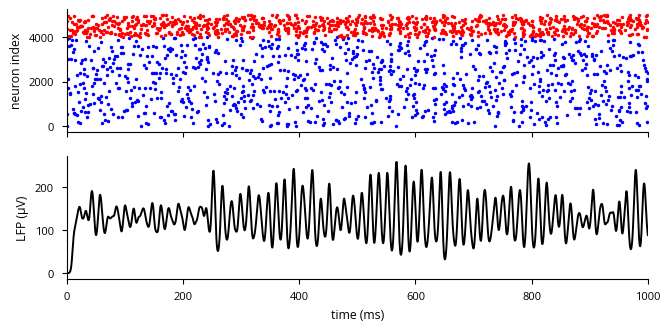

In [4]:
Nstp = 10  # step cell to draw
tick_size = 5

plt.style.use('seaborn-v0_8-paper')
fig, axes = plt.subplots(2, 1, figsize=(7.5, 3.5), sharex=True)

axes[0].plot(exc_cells[::Nstp]["time"], exc_cells[::Nstp]["cellid"], ".", c='b', ms=tick_size, rasterized=True)
axes[0].plot(inh_cells[::Nstp]["time"], inh_cells[::Nstp]["cellid"], ".", c='r', ms=tick_size, rasterized=True)

axes[1].plot(t_eval_ms, lfp, c='k')
axes[1].set_xlabel("time (ms)")
axes[1].set_xlim(0, tmax)

# prettify graph
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

axes[0].set(ylabel="neuron index")
axes[1].set(ylabel="LFP (μV)")
fig.savefig('tklfp-demo.pdf', transparent=True, dpi=300)

This looks identical to the original NEURON output, so I think we're in good shape.

![original output](original-demo-hoc-output.jpg)